# What are the best times on any day of the week to commute to/from work for a specific commute.

*Team Name: Data Ninjas

*Teammates: Molly Cox, Melissa Wright, Kat Anggasastra, Sreeteja Bollepalli


In [55]:
%matplotlib inline

In [56]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
#Cool Map Imports to get the maps to show up. 
import gmaps
import gmaps.datasets
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Sreeteja")

# Google developer API key
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)

In [57]:
# Create a list of times to find commute duration for
times_list_to_work = [5,6,7,8,9,10,11,12]
times_list_to_home = [13,14,15,16,17,18,19]
dates_list = ['3/2/2020','3/3/2020','3/4/2020','3/5/2020','3/6/2020','3/7/2020','3/8/2020']
home_location = 'Moffett Field, CA'
work_location = 'Salesforce Tower, CA'

In [58]:
# create a new list with combined dates/times into epoch time to be used to query database
pattern = '%m/%d/%Y-%H'
date_string = ''
datetime_list_to_work = []
datetime_list_to_home = []
times_df = pd.DataFrame(columns=["Commute Date", "Commute Start", "Epoch Time"])

for date_in in dates_list:
    
    for time_in in times_list_to_work:
        date_string = date_in + '-' + str(time_in)
        epoch = int(time.mktime(time.strptime(date_string, pattern)))
        datetime_list_to_work.append(epoch)
        times_df = times_df.append({
             "Commute Date": date_in,
             "Commute Start": time_in,
             "Epoch Time": epoch
          }, ignore_index=True)
        
    for time_in in times_list_to_home:
        date_string = date_in + '-' + str(time_in)
        epoch = int(time.mktime(time.strptime(date_string, pattern)))
        datetime_list_to_home.append(epoch)
        times_df = times_df.append({
             "Commute Date": date_in,
             "Commute Start": time_in,
             "Epoch Time": epoch
          }, ignore_index=True)

In [59]:
def get_commute_times(start_point, end_point, datetime_list):
    # Base info for google maps direction request
    # create a params dict that will be updated for each date/time
    params = {"key": gkey}
    base_url = "https://maps.googleapis.com/maps/api/directions/json"
    params['mode'] = 'driving'
    params['origin'] = start_point
    params['destination'] = end_point

    # Create dictionary to store {date_time: commute_time}
    commute_dict = {}
    
    # Loop through the date/times to get the period you are going to search for
    for commute_start in datetime_list:

        # update address key value
        params['departure_time'] = commute_start

        # make request
        commute_info = requests.get(base_url, params=params)
    
        # convert to json
        commute_info = commute_info.json()
    
        commute_time_legs = commute_info['routes'][0]['legs']
        total_route_time = 0
        for c_time in commute_time_legs:
            total_route_time = total_route_time + c_time['duration_in_traffic']['value']

        commute_dict[commute_start] = total_route_time
        time_here = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(commute_start))
        # print(f"Commute duration from {start_point} to {end_point} for {time_here} = {total_route_time/60} minutes")

        
    return commute_dict

In [60]:
#Script to get the map to show
#sources: https://stackoverflow.com/questions/13686001/python-module-for-getting-latitude-and-longitude-from-the-name-of-a-us-city
#sources: https://geopy.readthedocs.io/en/stable/
#**You must run this in your Terminal**  jupyter nbextension enable --py gmaps
home = geolocator.geocode(home_location)
#print(home.raw)
work = geolocator.geocode(work_location)
#print(work.raw)
#Get the Lattitudes and Longitudes for the map
home_coord = (home.latitude, home.longitude)
work_coord = (work.latitude, work.longitude)
#Display the Map
fig = gmaps.figure()
directions = gmaps.directions_layer(home_coord, work_coord)
fig.add_layer(directions)
fig

Figure(layout=FigureLayout(height='420px'))

In [61]:
# Get commute times for going to work
commute_to_work_dict = get_commute_times(home_location, work_location, datetime_list_to_work)

In [62]:
commute_to_work_df = pd.DataFrame.from_dict(commute_to_work_dict, orient='index', columns=['Commute Time'])
commute_to_work_df.index.name = 'Epoch Time'

In [63]:
# Get commute times for going home
commute_to_home_dict = get_commute_times(work_location, home_location, datetime_list_to_home)

In [64]:
commute_to_home_df = pd.DataFrame.from_dict(commute_to_home_dict, orient='index', columns=['Commute Time'])
commute_to_home_df.index.name = 'Epoch Time'

In [65]:
commute_to_work_df = pd.merge(commute_to_work_df,
                 times_df[['Commute Date', 'Commute Start', 'Epoch Time']],
                 on='Epoch Time')

In [66]:
commute_to_home_df = pd.merge(commute_to_home_df,
                 times_df[['Commute Date', 'Commute Start', 'Epoch Time']],
                 on='Epoch Time')

In [67]:
commute_to_work_df['Commute Name'] = f"{home_location } to {work_location}"

In [68]:
commute_to_home_df['Commute Name'] = f"{work_location} to {home_location}"

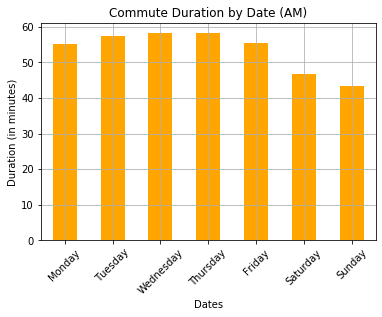

In [69]:
#Convert the seconds to minutes on commute 
commute_to_work_df['Minutes'] = commute_to_work_df['Commute Time']/60
days_of_week = ['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
# Split up our data into groups based upon 'date'
work_group = commute_to_work_df.groupby('Commute Date')
# Find out how long each day took 
work_trips = work_group['Minutes'].mean()
# Drop the 'stoptime' row that is contained within our group
#gender_trips = gender_trips.drop(gender_trips.index[3])
# Chart our data, give it a title, and label the axes
work_chart = work_trips.plot(kind="bar", title="Commute Duration by Date (AM)", color ='orange', rot=45)
work_chart.set_xlabel("Dates")
work_chart.set_ylabel("Duration (in minutes)")
work_chart.grid(b=True)
work_chart.set_xticklabels(days_of_week)

#Save the figure
plt.savefig("Images/Commute duration by Date (AM).png")

# Create a bar chart based upon the above data
plt.show()

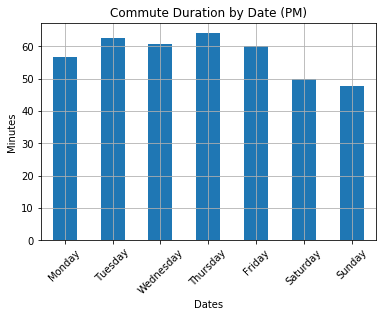

In [70]:
#Convert the seconds to minutes on commute 
commute_to_home_df['Minutes'] = commute_to_home_df['Commute Time']/60

#Split up our data into groups based upon 'date'
home_group = commute_to_home_df.groupby('Commute Date')

# Find out how long each day took 
home_trips = home_group['Minutes'].mean()

# Drop the 'stoptime' row that is contained within our group
#gender_trips = gender_trips.drop(gender_trips.index[3])

# Chart our data, give it a title, and label the axes
home_chart = home_trips.plot(kind="bar", title="Commute Duration by Date (PM)", rot = 45)
home_chart.set_xlabel("Dates")
home_chart.set_ylabel("Minutes")
home_chart.grid(b=True)
home_chart.set_xticklabels(days_of_week)

#Save the figure
plt.savefig("Images/Commute duration by Date (PM).png")

# Create a bar chart based upon the above data
plt.show()

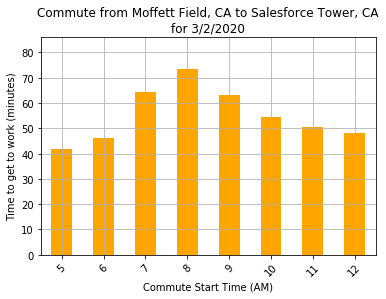

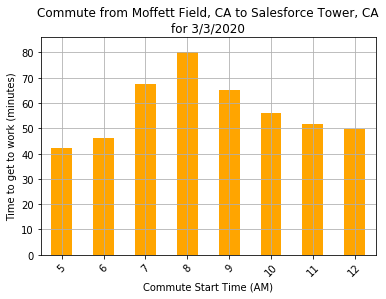

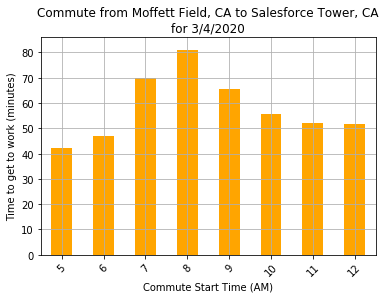

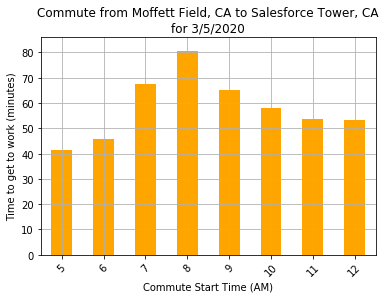

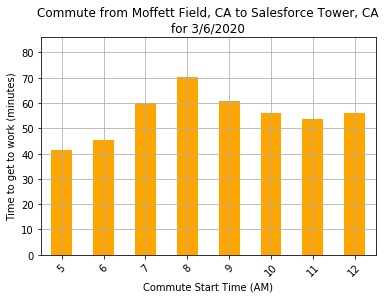

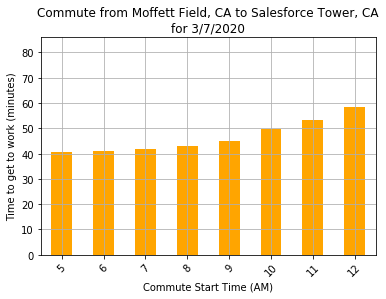

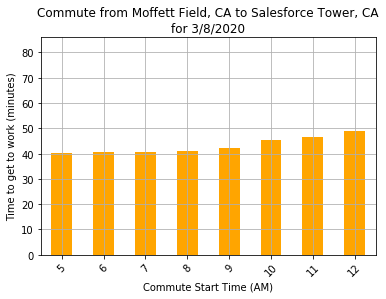

In [71]:
# Create 7 bar charts, one for each day of week, with start times we have stored as x-axis 
# and commute time in minutes as y-axis
s_times_list_to_work = [str(item) for item in times_list_to_work]
y_Max = round(commute_to_work_df['Commute Time'].max()/60)
#print(y_Max)
for day in dates_list:
    commute_to_plot_df = commute_to_work_df[commute_to_work_df['Commute Date'] == day]
    work_trips = commute_to_plot_df['Commute Time']/60
    work_times = work_trips.plot(kind="bar", title= f"Commute from {home_location} to {work_location}\nfor {day}", color="orange",rot=45)
    work_times.set_xlabel("Commute Start Time (AM)")
    work_times.set_ylabel("Time to get to work (minutes)")
    work_times.set_xticklabels(s_times_list_to_work)
    work_times.set_ylim(0, y_Max+5)
    work_times.grid(b=True)
    
    #Save the figure
    plt.savefig("Images/Commute Duration by Each day(AM)")
    plt.show()

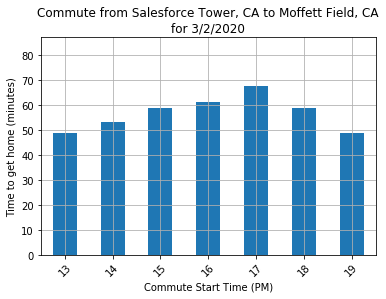

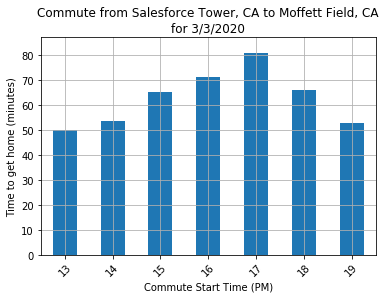

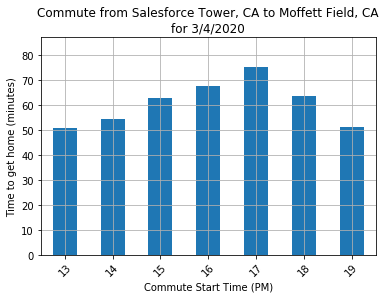

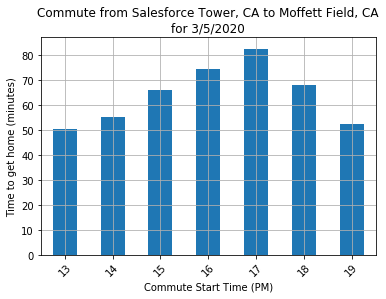

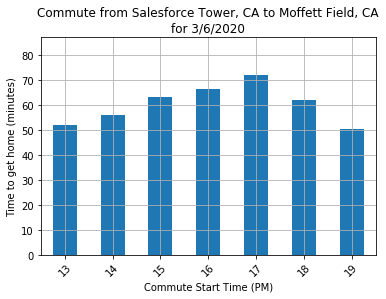

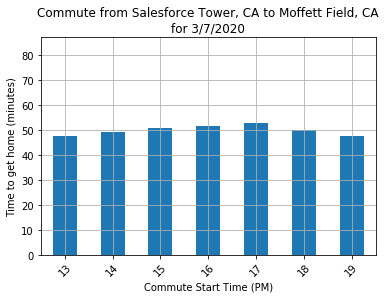

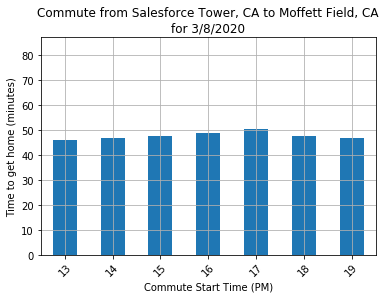

In [72]:
# Create 7 bar charts, one for each day of week, with start times we have stored as x-axis 
# and commute time in minutes as y-axis
s_times_list_to_home = [str(item) for item in times_list_to_home]
y_Max = round(commute_to_home_df['Commute Time'].max()/60)
#print(y_Max)
for day in dates_list:
    commute_to_plot_df = commute_to_home_df[commute_to_home_df['Commute Date'] == day]
    work_trips = commute_to_plot_df['Commute Time']/60
    work_times = work_trips.plot(kind="bar", title= f"Commute from {work_location} to {home_location}\nfor {day}",rot=45)
    work_times.set_xlabel("Commute Start Time (PM)")
    work_times.set_ylabel("Time to get home (minutes)")
    work_times.set_xticklabels(s_times_list_to_home)
    work_times.set_ylim(0, y_Max+5)
    work_times.grid(b=True)
    #save the figure
    plt.savefig("Images/Commute Duration by Each day(PM)")
    plt.show()